In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Qobj, basis, mesolve)
from joblib import Parallel, delayed

%matplotlib inline

In [2]:
delta = 0
omega0 = 100*np.pi
tf = 1 *2*np.pi/omega0
num_points = 1000

times = np.linspace(0, tf, num_points)

In [3]:
def omega(t, tf, tau, sigma, omega0, sign=1):
    return omega0 * np.exp(-(t - tf/2 - sign*tau)**2 / (sigma**2))

def omega_12g(t, tf, tau, sigma, omega0):
    return omega(t, tf, tau, sigma, omega0)

def omega_23g(t, tf, tau, sigma, omega0):
    return omega(t, tf, tau, sigma, omega0, -1)

In [4]:
def pulses(times, tf, tau, sigma, omega0):
    num_deriv = 2

    step = times[1] - times[0]
    t_ext = np.linspace(0, times[-1] + step*num_deriv , len(times) + num_deriv)

    omega12 = omega_12g(t_ext, tf, tau, sigma, omega0)
    omega23 = omega_23g(t_ext, tf, tau, sigma, omega0)

    theta = np.arctan(omega12/omega23)
    omegaa = np.diff(theta)/np.diff(t_ext)

    phi = np.arctan(omegaa/omega12[:-1])
    dphi = np.diff(phi, 1)/np.diff(t_ext[:-1])

    omega12p = np.sqrt(omega12[:-2]**2 + omegaa[:-1]**2)
    omega23p = omega23[:-2] - dphi
    return omega12p, omega23p

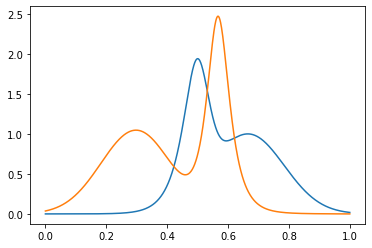

In [5]:
omega12, omega23 = pulses(times, tf, tf/6, tf/6, omega0)

plt.plot(times*omega0/(2*np.pi), omega12/omega0)
plt.plot(times*omega0/(2*np.pi), omega23/omega0)

In [6]:
def solvePopulations(times, pulse12, pulse23):
    psi0 = basis(3, 0)

    if len(times) < 2:
        return np.abs(np.array([psi0])) ** 2
    
    H0 = Qobj([[0, 0, 0], [0, delta, 0], [0, 0, 0]])
    H12 = Qobj([[0, -1, 0], [-1, 0, 0], [0, 0, 0]])
    H23 = Qobj([[0, 0, 0], [0, 0, -1], [0, -1, 0]])

    H = [H0, [H12, pulse12], [H23, pulse23]]

    result = mesolve(H, psi0, times)

    psi_t = np.array(result.states).reshape((len(times), 3))
    return np.abs(psi_t) ** 2

In [7]:
tf = 50 *2*np.pi/omega0
times = np.linspace(0, tf, num_points)
omega12_50C = omega_12g(times, tf, tf/6, tf/6, omega0)
omega23_50C = omega_23g(times, tf, tf/6, tf/6, omega0)
population50C = solvePopulations(times, omega12_50C, omega23_50C)

tf = 12 *2*np.pi/omega0
times = np.linspace(0, tf, num_points)
omega12_12C = omega_12g(times, tf, tf/6, tf/6, omega0)
omega23_12C = omega_23g(times, tf, tf/6, tf/6, omega0)
population12C = solvePopulations(times, omega12_12C, omega23_12C)

tf = 12 *2*np.pi/omega0
times = np.linspace(0, tf, num_points)
omega12_12, omega23_12 = pulses(times, tf, tf/6, tf/6, omega0)
population12 = solvePopulations(times, omega12_12, omega23_12)

tf = 1 *2*np.pi/omega0
times = np.linspace(0, tf, num_points)
omega12_1, omega23_1 = pulses(times, tf, tf/6, tf/6, omega0)
population1 = solvePopulations(times, omega12_1, omega23_1)

Text(0, 0.5, '$\\Omega_{12}$, $\\Omega_{23}$')

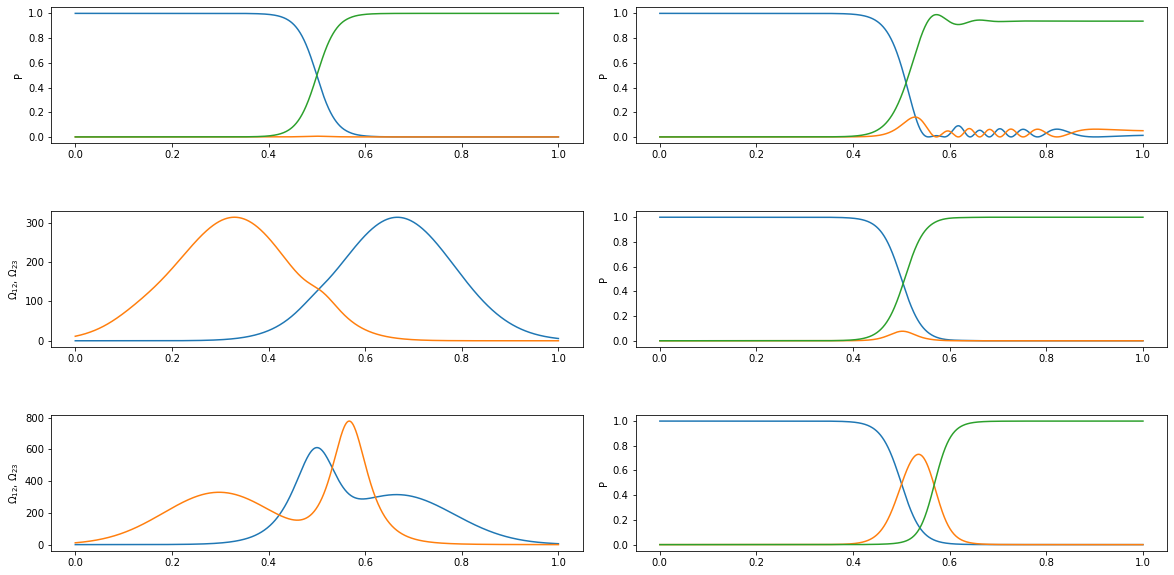

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

ax[0,0].plot(times*omega0/(2*np.pi), population50C)
ax[0,0].set_ylabel("P")

ax[0,1].plot(times*omega0/(2*np.pi), population12C)
ax[0,1].set_ylabel("P")

ax[1,1].plot(times*omega0/(2*np.pi), population12)
ax[1,1].set_ylabel("P")

ax[2,1].plot(times*omega0/(2*np.pi), population1)
ax[2,1].set_ylabel("P")

ax[1,0].plot(times*omega0/(2*np.pi), np.array([omega12_12, omega23_12]).T)
ax[1,0].set_ylabel(r'$\Omega_{12}$, $\Omega_{23}$')

ax[2,0].plot(times*omega0/(2*np.pi), np.array([omega12_1, omega23_1]).T)
ax[2,0].set_ylabel(r'$\Omega_{12}$, $\Omega_{23}$')